## The purpose of the dev version: to add source plane
## 1. From forward modeling
## 2. From delens

In [1]:
from os.path import expanduser
home = expanduser("~")

import sys
sys.path.insert(0, home+'/gigalens-xh-dev/src')

from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import sersic
from gigalens.jax.profiles.mass import epl, shear

import tensorflow_probability.substrates.jax as tfp
import jax
from jax import random
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt
import optax
tfd = tfp.distributions

# checking if using dev
import inspect
# import gigalens
import os

# print(gigalens.__file__)
print(inspect.getfile(os))
print(inspect.getfile(ModellingSequence))
print(inspect.getfile(PhysicalModel))

jax.device_count()

/global/homes/a/andigu/.conda/envs/jaxenv/lib/python3.7/os.py
/global/homes/x/xshuang/gigalens-xh-dev/src/gigalens/jax/inference.py
/global/homes/x/xshuang/gigalens-xh-dev/src/gigalens/model.py


4

In [ ]:
#!nvidia-smi

In [50]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(jnp.log(1.25), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
            )
        ),
        tfd.JointDistributionNamed(
            dict(gamma1=tfd.Normal(0, 0.05), gamma2=tfd.Normal(0, 0.05))
        ),
    ]
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(1.0), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
                Ie=tfd.LogNormal(jnp.log(500.0), 0.3),
            )
        )
    ]
)

source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(jnp.log(150.0), 0.5),
            )
        )
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)

In [51]:
prior

<tfp.distributions.JointDistributionSequential 'JointDistributionSequential' batch_shape=[[{center_x: [], center_y: [], e1: [], e2: [], gamma: [], theta_E: []}, {gamma1: [], gamma2: []}], [{Ie: [], R_sersic: [], center_x: [], center_y: [], e1: [], e2: [], n_sersic: []}], [{Ie: [], R_sersic: [], center_x: [], center_y: [], e1: [], e2: [], n_sersic: []}]] event_shape=[[{center_x: [], center_y: [], e1: [], e2: [], gamma: [], theta_E: []}, {gamma1: [], gamma2: []}], [{Ie: [], R_sersic: [], center_x: [], center_y: [], e1: [], e2: [], n_sersic: []}], [{Ie: [], R_sersic: [], center_x: [], center_y: [], e1: [], e2: [], n_sersic: []}]] dtype=[[{center_x: float32, center_y: float32, e1: float32, e2: float32, gamma: float32, theta_E: float32}, {gamma1: float32, gamma2: float32}], [{Ie: float32, R_sersic: float32, center_x: float32, center_y: float32, e1: float32, e2: float32, n_sersic: float32}], [{Ie: float32, R_sersic: float32, center_x: float32, center_y: float32, e1: float32, e2: float32, n_s

In [3]:
# note: here we're modeling the same demo system as in the paper

kernel = np.load('./src/gigalens/assets/psf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=60, supersample=2, kernel=kernel)
phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
observed_img = np.load('./src/gigalens/assets/demo.npy')
prob_model = ForwardProbModel(prior, observed_img, background_rms=0.2, exp_time=100)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

## show the simulated image -- use the TF demo

## How do I get the truth of the sampled parameters?

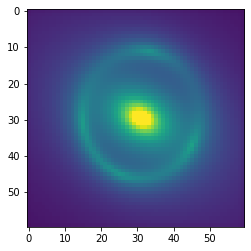

In [49]:
import matplotlib as mpl
truth = [[
    {'theta_E': 1.1, 'gamma': 2.0, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.0},
    {'gamma1': -0.01, 'gamma2': 0.03}
], [
    {'R_sersic': 0.8, 'n_sersic': 2.5, 'e1': 0.09534746574143645, 'e2': 0.14849487967198177, 'center_x': 0.1, 'center_y': 0.0, 'Ie': 499.3695906504067}
], [
    {'R_sersic': 0.25, 'n_sersic': 1.5, 'e1': 0., 'e2': 0., 'center_x': 0.09566681002252231, 'center_y': -0.0639623054267272, 'Ie': 149.58828877085668}
]]

plt.imshow(lens_sim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)



Chi-square: 0.9812517


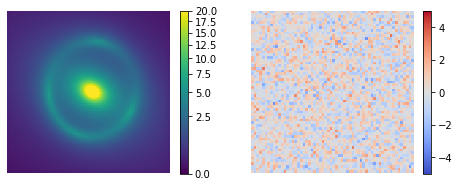

In [52]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.imshow(lens_sim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)
plt.colorbar()
plt.axis('off')
plt.subplot(122)
simulated = lens_sim.simulate(truth)
resid = simulated - observed_img
background_rms, exp_time = 0.2, 100
err_map = np.sqrt(background_rms**2 + simulated/exp_time)
plt.imshow(resid/err_map, cmap='coolwarm', interpolation='none', vmin=-5, vmax=5)
print('Chi-square:', np.mean((resid/err_map)**2))
plt.axis('off')
plt.colorbar()

In [80]:
map_samples = 100

map_steps = 300
transition_steps = 300

seed, lr_start, lr_end, pwr = 0, -1e-2, -1e-2/3, 0.5

schedule_fn = optax.polynomial_schedule(init_value=lr_start, end_value=lr_end, 
                                      power=pwr, transition_steps=transition_steps)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
map_estimate, chi2_hist = model_seq.MAP(opt, seed=0, n_samples=map_samples, num_steps=map_steps)
# map_estimate = model_seq.MAP(opt, seed=0, n_samples=30, num_steps=num_steps)

DEV version!!!


  0%|          | 0/300 [00:00<?, ?it/s]

In [81]:
# If I want to save the results
import pickle
from datetime import datetime
hyper_params = [map_steps, transition_steps, seed, lr_start, lr_end, pwr]

date = datetime.now().strftime("%Y_%m_%d-%H:%M")
with open(f"saved-maps/map_est_{date}.pickle", 'wb') as f:
    pickle.dump((map_estimate, chi2_hist, hyper_params), f)

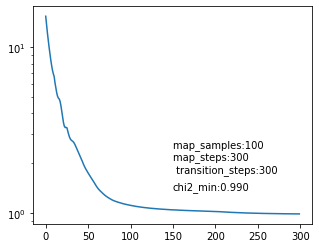

In [82]:
chi2_arr = np.array(chi2_hist)
chi2_min = chi2_arr.min()
map_samples = map_estimate.shape[0]
# map_steps, transition_steps, seed = hyper_params

# map_steps, transition_steps, seed, lr_start, lr_end, pwr = hyper_params

lr_start, lr_end, pwr = -1e-2, -1e-2/4, 0.5

plt.figure(figsize=(5, 4))
plt.plot(chi2_hist)
plt.yscale('log')
plt.text(map_steps*0.5, chi2_min*1.4, 'chi2_min:{:.3f}'.format(chi2_min))
hyper_p = 'map_samples:{:d} \n\
map_steps:{:d}  \n \
transition_steps:{:d} \n'.format(map_samples, map_steps, transition_steps) #, seed, lr_start, lr_end, pwr) 
# hyper_p = 'map_samples:{:d} \n'.format(map_samples) #, map_steps, transition_steps, seed, lr_start, lr_end, pwr) 

plt.text(map_steps*0.5, chi2_min*1.5, hyper_p)
# plt.ylim(2.5, 6)
plt.show()


In [7]:
lps = prob_model.log_prob(LensSimulator(phys_model, sim_config, bs=map_samples), map_estimate)[0]
best = map_estimate[jnp.argmax(lps)][jnp.newaxis,:]

## Add source plane reconstruction

## Also find the light amplitude, Ie

In [8]:
phys_params = prob_model.bij.forward(list(map_estimate.T))

params = phys_params
print(len(params[0][0]))
lens_params = params[0]


6


shapes of img_X, img_Y: (120, 120, 1) (120, 120, 1)
(120, 120, 1)
lens light component,  0
(120, 120, 100)
(120, 120, 100)


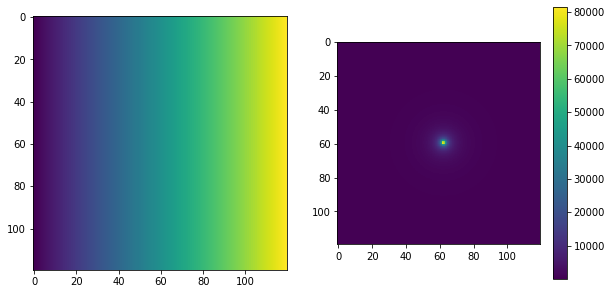

In [9]:
print('shapes of img_X, img_Y:', lens_sim.img_X.shape, lens_sim.img_Y.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(lens_sim.img_X[..., 0])
ax2.imshow(lens_sim.img_Y[..., 0])



if len(lens_sim.phys_model.lens_light) > 0:
    lens_light_params, source_light_params = params[1], params[2]

    # print('lens_light_params', lens_light_params)
    # print('source_light_params', source_light_params)

else:
    source_light_params = params[1]



# insert a 0 at the front allows multiple light components to be concatenated
img_xh = jnp.zeros(lens_sim.img_X.shape)
print(img_xh.shape)
i = 0
for lightModel, p in zip(lens_sim.phys_model.lens_light, lens_light_params):
    print('lens light component, ', i)
    # print(p)
    # img = jnp.concatenate((img, lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p)), axis=0)
    print(lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p).shape)
    img_xh += lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p)
    i += 1
    
print(img_xh.shape)
lens_light_model = img_xh[..., 0].squeeze()

plt.imshow(lens_light_model)
plt.colorbar()

(120, 120, 1)
source light component,  0
(120, 120, 100)
(120, 120, 100)


AttributeError: 'AxesImage' object has no property 'lower'

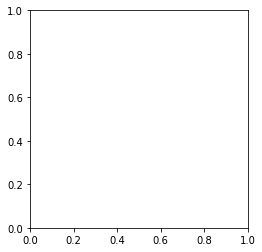

In [77]:
# I think this is the source light

# insert a 0 at the front allows multiple light components to be concatenated
img_xh_s = jnp.zeros(lens_sim.img_X.shape)
print(img_xh_s.shape)
# img = jnp.concatenate((img, lightModel.light(beta_x, beta_y, **p)), axis=0)

i = 0
for lightModel, p in zip(lens_sim.phys_model.source_light, source_light_params):
    print('source light component, ', i)
    #print('beta x and y shapes:', beta_x.shape, beta_y.shape)
    # print(p)
    # img = jnp.concatenate((img, lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p)), axis=0)
    print(lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p).shape)
    img_xh_s += lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p)
    i += 1
    
print(img_xh_s.shape)
plt.imshow(img_xh_s[..., 0].squeeze(), lower='lower')

In [55]:
# more readable form 
def extract_params(best_params):

    mass_params = ['theta_E', 'gamma', 'e1', 'e2', 'center_x', 'center_y']
    shear_params = ['gamma1', 'gamma2']
    # if not using linear inversion -- then Ie is included
    light_params = ['R_sersic', 'n_sersic', 'e1', 'e2','center_x', 'center_y', 'Ie']
    # if using linear inversion -- then no Ie
    # light_params = ['R_sersic', 'n_sersic', 'e1', 'e2','center_x', 'center_y']

    count = 0
    for i in range(len(best_params)):
        if i==0:
            print('Lens mass params ({:d} sets):'.format(len(best_params[i])))
        elif i==1:
            print('Lens light params({:d} sets):'.format(len(best_params[i])))
        elif i==2:
            print('Source light params({:d} sets):'.format(len(best_params[i])))
        for j in range(len(best_params[i])):
            if j > 0:
                print()
            for k in range(len(best_params[i][j])):
                if i==0:
                    if j==0:
                        print('{:5s}={:6.3f}  '.format(mass_params[k], best_params[i][j][mass_params[k]]), end='')
                    elif j==1:
                        print('{:5s}={:6.3f}  '.format(shear_params[k], best_params[i][j][shear_params[k]]), end='')

                else:
                    print('{:5s}={:6.3f}  '.format(light_params[k], best_params[i][j][light_params[k]]), end='')

                count += 1
        print('\n')

# note here, we didn't use linear inversion so the brigtness, Ie, was fit for too.
best_params = prob_model.bij.forward(list(map_estimate[np.nanargmax(lps)]))   
        
extract_params(best_params)
print('Compared with truth: \n')

extract_params(truth)
# chi2_ar = chi2_arr[-100:]
print('min chi2: {:4.3f}'.format(chi2_arr.min()))

Lens mass params (2 sets):
theta_E= 1.113  gamma= 2.442  e1   = 0.213  e2   = 0.176  center_x= 0.108  center_y= 0.005  
gamma1=-0.022  gamma2= 0.018  

Lens light params(1 sets):
R_sersic= 0.812  n_sersic= 2.341  e1   = 0.095  e2   = 0.131  center_x= 0.100  center_y= 0.001  Ie   =517.048  

Source light params(1 sets):
R_sersic= 0.244  n_sersic= 0.955  e1   =-0.152  e2   = 0.007  center_x= 0.098  center_y=-0.099  Ie   =273.180  

Compared with truth: 

Lens mass params (2 sets):
theta_E= 1.100  gamma= 2.000  e1   = 0.100  e2   = 0.100  center_x= 0.100  center_y= 0.000  
gamma1=-0.010  gamma2= 0.030  

Lens light params(1 sets):
R_sersic= 0.800  n_sersic= 2.500  e1   = 0.095  e2   = 0.148  center_x= 0.100  center_y= 0.000  Ie   =499.370  

Source light params(1 sets):
R_sersic= 0.250  n_sersic= 1.500  e1   = 0.000  e2   = 0.000  center_x= 0.096  center_y=-0.064  Ie   =149.588  

min chi2: 1.185


Chi-square: 1.1829047


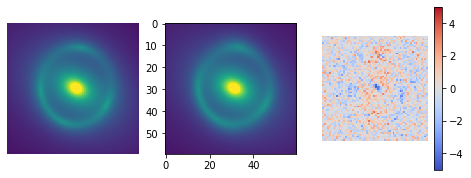

In [58]:
# compare best-fit parameters with observed image
plt.figure(figsize=(8, 3))
plt.subplot(131)
plt.imshow(lens_sim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)
# plt.colorbar()
plt.axis('off')
plt.subplot(132)
simulated = lens_sim.simulate(best_params)
plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)

plt.subplot(133)
resid = simulated - observed_img
background_rms, exp_time = 0.2, 100
err_map = np.sqrt(background_rms**2 + simulated/exp_time)
plt.imshow(resid/err_map, cmap='coolwarm', interpolation='none', vmin=-5, vmax=5)
print('Chi-square:', np.mean((resid/err_map)**2))
plt.axis('off')
plt.colorbar()

# next use WS code to get the source plane 

In [69]:
from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.lens_model import LensModel

# Why does the source position doesn't seem to be very close to the center of the caustic?
# Check if the source position is right? Since I'm using the truth here.

(60, 60)


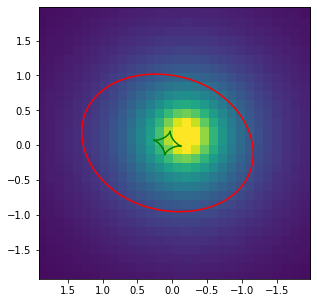

In [76]:
delta_pix=0.065
num_pix = 60

lensModel = LensModel(lens_model_list=['EPL', 'SHEAR'], multi_plane=False)
kwargs_lens = truth[0]


phys_model_t = PhysicalModel([], [sersic.SersicEllipse(use_lstsq=False)], [])
sim_config_t = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=2, kernel=kernel)
lens_sim_t = LensSimulator(phys_model_t, sim_config_t, bs=1)
x = lens_sim_t.simulate([[], truth[2], []])
# off = -(size-2)

print(x.shape)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, fast_caustic=True, coord_inverse=True, with_convergence=False, deltaPix=delta_pix, numPix=num_pix, )


scale_extent = 1.

# extent = (num_pix*delta_pix)/scale_extent, -(num_pix*delta_pix)/scale_extent, \
#          -(num_pix*delta_pix)/scale_extent, (num_pix*delta_pix)/scale_extent,


extent = (num_pix*delta_pix), -(num_pix*delta_pix), -(num_pix*delta_pix), (num_pix*delta_pix)


ax.imshow(x, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=2.0), extent=extent)


In [ ]:
vs = 0.05
lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=lens_params, with_caustics=True, fast_caustic=True, coord_inverse=False, deltaPix=0.015/scale, numPix=int(275*scale))
size = 58
scale_extent = 1.8

imnorm = mpl.colors.PowerNorm(0.5, vmin=0, vmax=20)
extent = (size*delta_pix)/scale_extent, -(size*delta_pix)/scale_extent, -(size*delta_pix)/scale_extent, (size*delta_pix)/scale_extent,

# I do the same as WS -- rotating the image by 180 deg relative to the caustic.  I'm not sure why.
src_model = np.rot90(np.rot90(img_sp_tot[..., 0]))

#### plot model for arc together with data
arcs_model_rot = np.rot90(np.rot90(arcs_model))
ax.imshow(src_model+arcs_model_rot, extent=extent, norm=imnorm, cmap='plasma')

source light component,  0
(120, 120, 100)
(120, 120, 100)


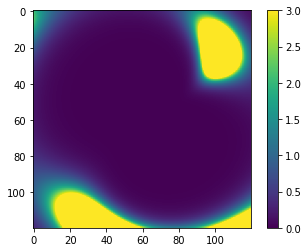

In [47]:
# ---> if I apply deriv to to this, I should get the source plane

# ---> but I should know what happened in lightModel.light()!!!!

# insert a 0 at the front allows multiple light components to be concatenated


beta_x, beta_y = lens_sim._beta(lens_params)

img_xh_s = jnp.zeros(lens_sim.img_X.shape)

# img = jnp.concatenate((img, lightModel.light(beta_x, beta_y, **p)), axis=0)

i = 0
for lightModel, p in zip(lens_sim.phys_model.source_light, source_light_params):
    # print('source light component, ', i)
    # print(p)
    # img = jnp.concatenate((img, lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p)), axis=0)
    print('source light component, ', i)
    # print(p)
    # img = jnp.concatenate((img, lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p)), axis=0)
    print(lightModel.light(beta_x, beta_y, **p).shape)

    img_xh_s += lightModel.light(beta_x, beta_y, **p)

    i += 1
print(img_xh_s.shape)

arcs_model = img_xh_s[..., 0].squeeze()
plt.imshow(arcs_model, vmin=0, vmax=3)
plt.colorbar()



## Next: add cautic and critical curves -- reproduce one of the four archetypes

## VI and HMC steps

In [ ]:
schedule_fn = optax.polynomial_schedule(init_value=-1e-6, end_value=-3e-3, 
                                      power=2, transition_steps=300)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
qz, loss_hist = model_seq.SVI(best, opt, n_vi=100, num_steps=100)
# qz, loss_hist = model_seq.SVI(best, opt, n_vi=1000, num_steps=1500)

In [ ]:
plt.plot(loss_hist)

In [ ]:
samples = model_seq.HMC(qz, num_burnin_steps=20, num_results=70)

In [ ]:
rhat= tfp.mcmc.potential_scale_reduction(jnp.transpose(samples.all_states, (1,2,0,3)), independent_chain_ndims=2)

In [ ]:
rhat